In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')

## Определение функций

Функции написаны в соответствии с классическим алгоритмом, описанным, например в Golyandina N., Nekrutkin V., Zhigljavsky A. *Analysis of Time Series Structure, 2001*. 

Позже планируется оформление в классы.

In [2]:
def henkelization(X):
    '''
    X: numpy 2d array
    
    return: numpy 1d array
    '''
    X_rev = X[::-1]
    return np.array([X_rev.diagonal(i).mean() for i in range(-X.shape[0]+1, X.shape[1])])

class SSA:
    def __init__(self, l = None, rank = None):
        '''
        l: int, window size
        rank: int, restriction for rank in SVD
        '''
        self.l = l if l is not None else 10
        self.rank = rank
        
    def transform_to_matrix(self, series):
        '''
        series: numpy 1d array object with length n

        return: np.array 3-d tensor shape (rank, l, n-l+1)
        '''
        
        K = series.shape[0] - self.l + 1
        X = np.column_stack([series[i:self.l+i] for i in range(K)])


        U, sigma, VT = np.linalg.svd(X, full_matrices = False, hermitian = False)

        X_output = []
        bond = len(sigma) if self.rank is None else self.rank
        for i in range(bond):
            if sigma[i] > 0:
                X_i = sigma[i] * U[:,i].reshape(U.shape[0], 1) @ VT[i,:].reshape(1, VT.shape[1])
                X_output.append(X_i)
        return np.array(X_output)
    
    def transform_to_series(self, series):
        '''
        series: numpy 1d array object with length

        return: np.array 2-d tensor shape (rank, n)
        '''
        K = series.shape[0] - self.l + 1
        X = np.column_stack([series[i:self.l+i] for i in range(K)])


        U, sigma, VT = np.linalg.svd(X, full_matrices = False, hermitian = False)

        X_output = []
        bond = len(sigma) if self.rank is None else self.rank
        for i in range(bond):
            if sigma[i] > 0:
                X_i = sigma[i] * U[:,i].reshape(U.shape[0], 1) @ VT[i,:].reshape(1, VT.shape[1])
                X_output.append(X_i)
                
        X_output = [henkelization(X_i) for X_i in X_output]
        return np.array(X_output)
        
        

## Эксперименты с данными 

Используем данные о помесячном производстве пива в США 1956-1995. Данные взяты с [kaggle.com](https://www.kaggle.com/datasets/jessemostipak/beer-production/data)

In [3]:
# данные из https://www.kaggle.com/datasets/jessemostipak/beer-production/data
ts = pd.read_csv('beer_production.csv')['Monthly beer production'].to_numpy()
ssa = SSA(rank = 5, l = 20)

ssa.transform_to_series(ts).sum(axis = 0) # получение итогового аппроксимированного ряда
clear_output()

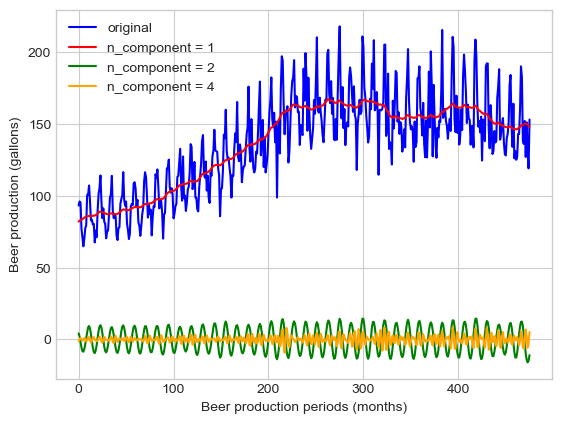

In [10]:
ssa = SSA(l = 10)
ts_outputs = ssa.transform_to_series(ts)
ts_1 = ts_outputs[0, :]
ts_2 = ts_outputs[1, :]
ts_3 = ts_outputs[3, :]

fig, ax = plt.subplots()
x = np.arange(0,ts.shape[0])
ax.plot(ts, c = 'b', label = 'original')
ax.plot(ts_1, c = 'r', label = 'n_component = 1')
ax.plot(ts_2, c = 'g', label = 'n_component = 2')
ax.plot(ts_3, c = 'orange', label = 'n_component = 4')

ax.set_xlabel('Beer production periods (months)')
ax.set_ylabel('Beer production (gallons)')
plt.legend()
plt.savefig('Fig 2. Components in SSA.png', dpi = 300);

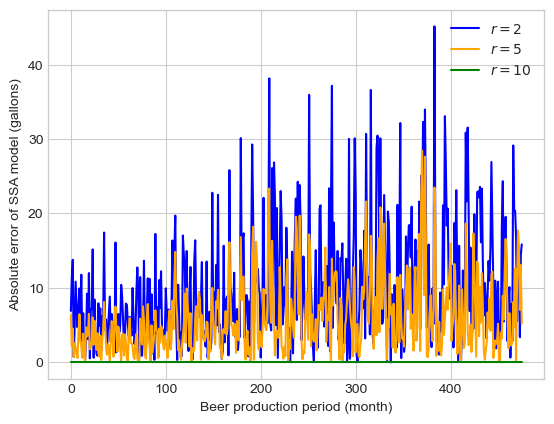

In [15]:
# как ведет себя ошибка при увеличении ранга аппроксимации
ssa = SSA(l = 10)
ts_outputs = ssa.transform_to_series(ts)
ts_1 = ts_outputs[:2, :].sum(axis = 0)
ts_2 = ts_outputs[:5, :].sum(axis = 0)
ts_3 = ts_outputs[:10, :].sum(axis = 0)

x = np.arange(0,ts.shape[0])
error_1 = np.abs(ts - ts_1)
error_2 = np.abs(ts - ts_2)
error_3 = np.abs(ts - ts_3)

fig, ax = plt.subplots()
ax.plot(error_1, c = 'b', label  = '$r=2$')
ax.plot(error_2, c = 'orange', label = '$r=5$')
ax.plot(error_3, c = 'g', label = '$r=10$')

ax.set_xlabel('Beer production period (month)')
ax.set_ylabel('Absolute error of SSA model (gallons)')
plt.legend()
plt.savefig('Fig 3. Dependence of error with increasing rank.png', dpi = 300);

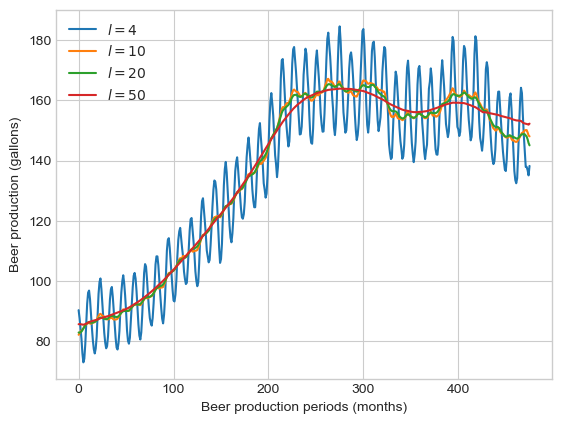

In [16]:
# посмотрим на изменение первой компоненты при разных параметрах окна

window_lengths = [4,10,20,50]
fig, ax = plt.subplots()
for l in window_lengths:
    ssa = SSA(l = l)
    ts_approx = ssa.transform_to_series(ts)[0, :]
    
    ax.plot(ts_approx, label = f'$l = {l}$')

ax.set_ylabel('Beer production (gallons)')
ax.set_xlabel('Beer production periods (months)')
plt.legend();
plt.savefig('Fig 4. Dependecy from widow length.png', dpi = 300)

In [17]:
# посмотрим на время работы алгоритма
from time import time
from tqdm import tqdm

time_complexity = []
for n in tqdm(range(4,10**5, 100)):
    ts = np.random.normal(size = (n,))
    start = time()
    
    ssa = SSA(l = 4)
    ts_new = ssa.transform_to_series(ts).sum(axis = 0)

    end = time()
    
    time_complexity.append(end-start)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [44:46<00:00,  2.69s/it]


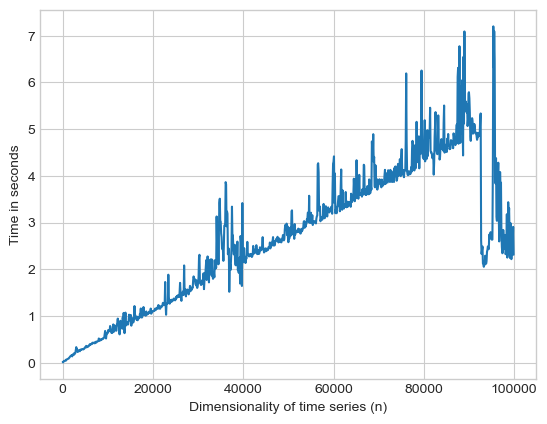

In [19]:
# действительно, ассимптотика в случае l < n-l+1 похожа на линейную с 
fig, ax = plt.subplots()
ax.plot(range(4,10**5,100), time_complexity);
ax.set_ylabel('Time in seconds')
ax.set_xlabel('Dimensionality of time series (n)');
plt.savefig('Fig 1. Computation time of SSA_2.png')

MovieWriter ffmpeg unavailable; using Pillow instead.


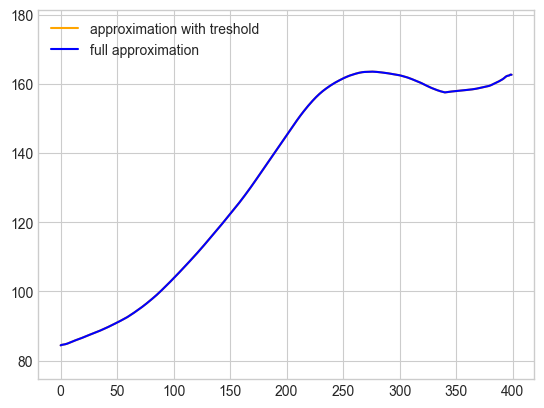

In [5]:
# попробуем посмотреть, что меняется, если взять больше наблюдений 
# если treshold взять близким к 400, то временные ряды будут очень сильно совпадать
from matplotlib.animation import ArtistAnimation

fig, ax = plt.subplots()
frames = []

for treshold in range(80,401):
    ts_1 = ts[:treshold]
    ts_2 = ts[:400]
    
    ssa = SSA(l = 60)
    ssa_ts_1 = ssa.transform_to_series(ts_1)[0, :]
    ssa_ts_2 = ssa.transform_to_series(ts_2)[0, :treshold] # full time series component

    line = ax.plot(range(treshold), ssa_ts_1, 'orange', range(treshold), ssa_ts_2, 'blue')
    frames.append(line)

ax.legend(['approximation with treshold', 'full approximation'])
animation = ArtistAnimation(fig, frames, interval = 10, blit = True, repeat = True) 
animation.save('Gif4.gif', fps = 60)
plt.show()

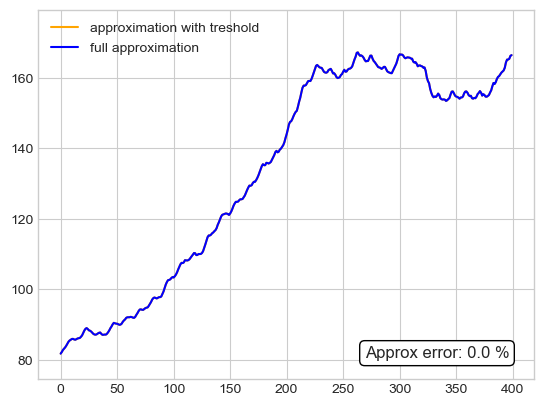

In [10]:
from matplotlib.animation import ArtistAnimation

fig, ax = plt.subplots()
frames = []

for treshold in range(30,401):
    ts_1 = ts[:treshold]
    ts_2 = ts[:400]
    
    ssa = SSA(l = 10)
    ssa_ts_1 = ssa.transform_to_series(ts_1)[0, :]
    ssa_ts_2 = ssa.transform_to_series(ts_2)[0, :treshold] # full time series component

    line = ax.plot(range(treshold), ssa_ts_1, 'orange', range(treshold), ssa_ts_2, 'blue')

    percentage_error = 100 * np.abs(ssa_ts_1[-1] - ssa_ts_2[-1]) / ssa_ts_2[-1]
    text = ax.text(0.95,0.05, f'Approx error: {round(percentage_error,1)} %', ha = 'right', 
            va = 'bottom', transform=ax.transAxes, fontsize = 12,
           bbox=dict(boxstyle='round', facecolor='white', edgecolor='black'))
    
    frames.append(line + [text])

    

ax.legend(['approximation with treshold', 'full approximation'])
animation = ArtistAnimation(fig, frames, interval = 10, blit = True, repeat = True) 
animation.save('Gif4.gif', fps = 60)
plt.show()


In [9]:
from collections import defaultdict

def get_index(array):
    q1 = np.quantile(array,0.25)
    q3 = np.quantile(array,0.75)
    indexes = np.where(array > q3 + 1.5*(q3 - q1))[0]
    n = array.shape[0]
    indexes[indexes > (n-1) // 2] -= n

    return indexes

def analyse_component(ts, l = 10, n_component = 2):

    results = {}

    for threshold in range(l+20,ts.shape[0]):
        ts_1 = ts[:threshold]
        ts_2 = ts[:ts.shape[0]]

        ssa = SSA(l = l)
        ssa_ts_1 = ssa.transform_to_series(ts_1)[n_component-1, :]
        ssa_ts_2 = ssa.transform_to_series(ts_2)[n_component-1, :threshold]
        results[f'vector_{threshold}'] = np.abs(ssa_ts_1 - ssa_ts_2)
        results[f'norm_{threshold}'] = np.linalg.norm(ssa_ts_1 - ssa_ts_2)
        results[f'appromixation_{threshold}'] = np.abs(ssa_ts_1 - ts[:threshold])
        

    index_frequency = defaultdict(lambda:0)
    mean_len = 0
    for threshold in range(l+20,ts.shape[0]):
        indexes = get_index(results[f'vector_{threshold}'])
        for index in indexes:
            index_frequency[index] += 1
        mean_len += len(indexes) / (ts.shape[0] - l - 20) 

    norms = [results[f'norm_{threshold}'] for threshold in range(l+20,ts.shape[0])]

    return results, norms, index_frequency, mean_len

def plot_frequencies(index_frequency, l, n_component, ax = None):
    index_frequency_map = sorted(index_frequency.items(), key = lambda x: x[0], reverse = True)
    y_ticks = np.array(list(map(lambda x: str(x[0]), index_frequency_map)))
    x_ticks = np.array(list(map(lambda x: x[1], index_frequency_map)))
    
    y_locator = [0, np.argmax(x_ticks),  y_ticks.shape[0] - 1]
    
    if ax is not None:
        sns.barplot(x = x_ticks, 
                    y = y_ticks, 
                    orient = 'h', ax = ax)
        
        ax.set_yticks(y_locator, y_ticks[y_locator])
        
        ax.set_ylabel('ranged indexes')
        ax.set_xlabel('frequency')
        ax.set_title(f'$l = {l}$, $n\_component = {n_component}$');
    else:
        sns.barplot(x = x_ticks, 
                    y = y_ticks, 
                    orient = 'h', ax = ax)
        
        plt.yticks(y_locator, y_ticks[y_locator])
        
        plt.ylabel('ranged indexes')
        plt.xlabel('frequency')
        plt.title(f'$l = {l}$, $n\_component = {n_component}$');

Почему важно это анализировать?
Оказалось, что дополнительная информация сильнее всего влияет на последние компоненты ряда. А это плохо для предсказаний. Но что тогда можно сделать с этим?

Правда ли, что самые неточные предсказания в конце ряда?

**Грустный итог** 

Вполне возможно, что гипотеза выше верна (это нужно будет проверить на примерах), и соответственно корректировать выбор ранга LRF в зависимости от длинны окна (эту зависимость тоже надо выявить). 

Неверное, что компоненты одинаково себя ведут без и с дополнительной информацией. Чтобы убедиться, достаточно посмотреть на 4-ую компоненту, см. gif 3. 

Mean number of higly deviant observations: 10.204035874439462


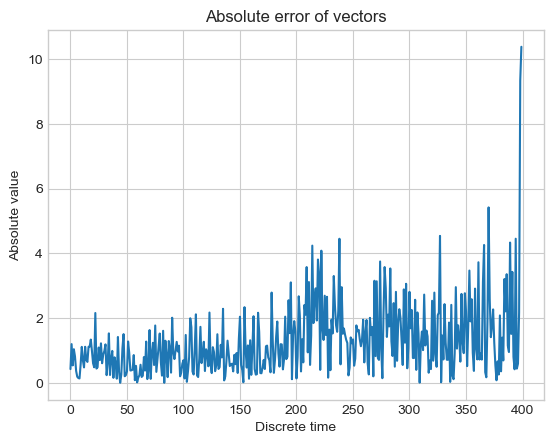

In [17]:
results, norms, index_frequency, mean_len = analyse_component(ts, l= 10, n_component=4)

print(f'Mean number of higly deviant observations: {mean_len}')
plt.plot(results['vector_400'])
plt.title('Absolute error of vectors')
plt.xlabel('Discrete time')
plt.ylabel('Absolute value');

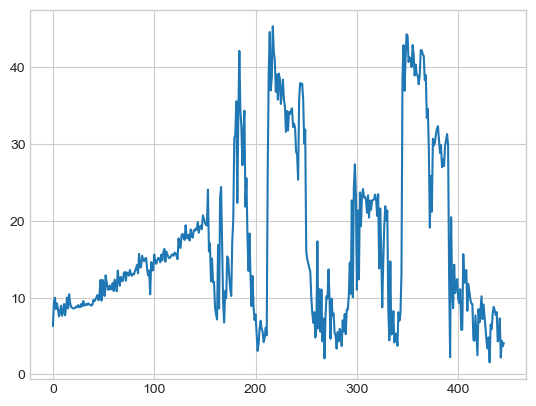

In [18]:
plt.plot(norms);

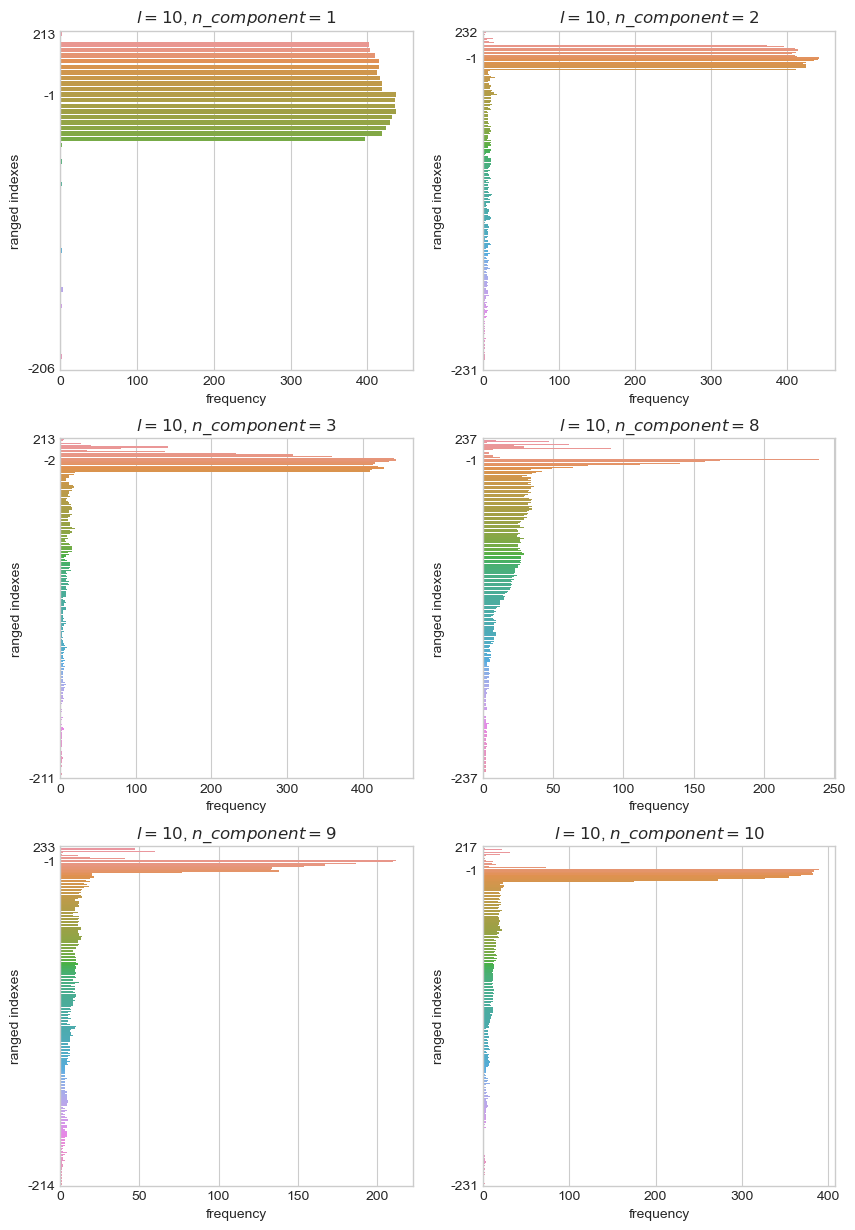

In [14]:
# с данным окном l = 10 проведём анализ компонент 1,2,3,8,9,10

fig, ax = plt.subplots(3,2, figsize = (10,15))

for i, n_component in enumerate([1,2,3,8,9,10]):


    _, _, index_frequency, _ = analyse_component(ts, l= 10, n_component=n_component)

    plot_frequencies(index_frequency, l = 10, n_component=n_component, ax = ax[i//2][i%2])

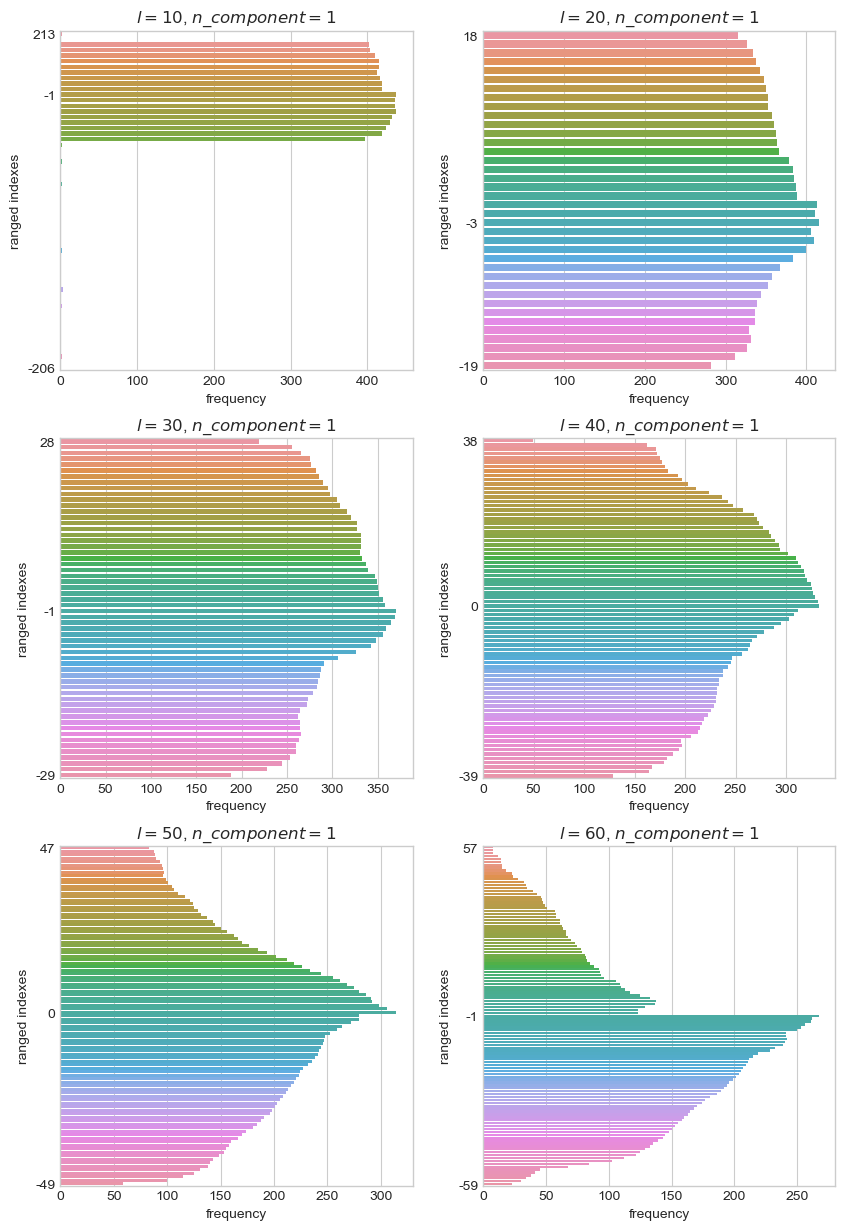

In [52]:
fig, ax = plt.subplots(3,2, figsize = (10,15))
n_component = 1
l_list = [10,20,30,40,50,60]
mean_len_list = []

for i, l in enumerate(l_list):


    _, _, index_frequency, mean_len = analyse_component(ts, l= l, n_component=n_component)
    mean_len_list.append(mean_len)
    plot_frequencies(index_frequency, l = l, n_component=n_component, ax = ax[i//2][i%2])

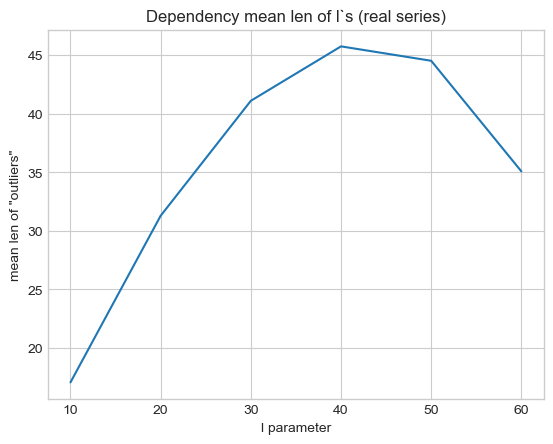

In [53]:
plt.plot(l_list, mean_len_list)
plt.xlabel('l parameter')
plt.ylabel('''mean len of "outliers"''')
plt.title('Dependency mean len of l`s (real series)');
plt.savefig('Fig.6 Dependency mean len of l`s (real series).png', dpi = 300)

In [7]:
## Часть с исследованием ошибки аппроксимации

def analyse_approximation(ts, l, rank):
    ssa = SSA(l = l)
    ts_approx = ssa.transform_to_series(ts)[:rank-1, :].sum(axis = 0)
    
    absolute_error = np.abs(ts - ts_approx)
    indexes = get_index(absolute_error)
    
    index_frequency = defaultdict(lambda:0)
    for index in indexes:
        index_frequency[index] += 1
    
    return absolute_error, index_frequency

In [10]:
absolute_error, index_frequency = analyse_approximation(ts, l = 50, rank = 20)

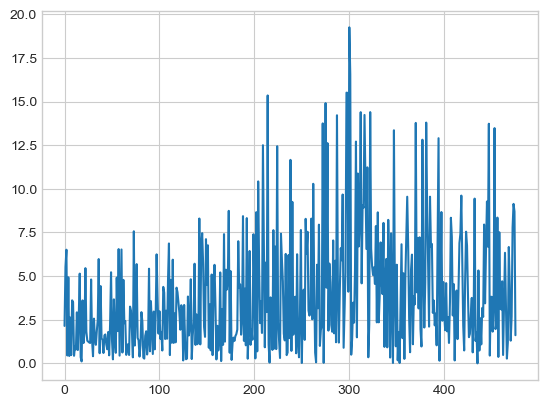

In [53]:
plt.plot(absolute_error);

Exponential-cosine series:
$$
f_n = A\exp^{\alpha n}\cos{(2\pi \omega n + \phi)}
$$

$A \neq 0, \alpha \in (0,1), \omega \in (0,1/2)$

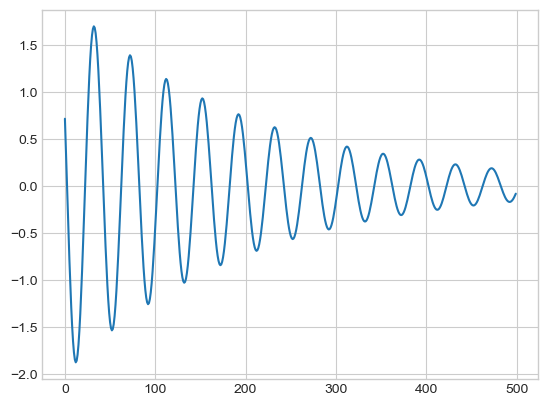

In [5]:
# синтетические данные 
x = np.linspace(1,500, 500)

def exp_cosine(x, A, w, alpha, phi):
    return A*np.exp(alpha*x)*np.cos(2*np.pi*w*x + phi)

exp_cosine_np = np.vectorize(exp_cosine, excluded = ['A', 'w','alpha','phi'])
ts_expcosine = exp_cosine_np(x, A = 2, w = 0.025, alpha = -0.005, phi = np.pi / 3)
plt.plot(ts_expcosine);

(10, 500)


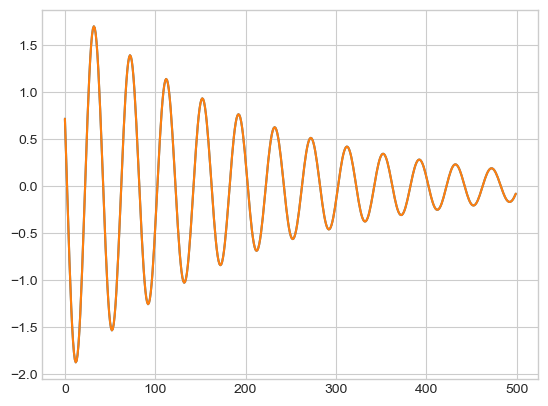

In [29]:
# хочу посмотреть на ранг
ts_ssa = SSA(l = 10).transform_to_series(ts_expcosine)
print(ts_ssa.shape)
plt.plot(ts_expcosine)
plt.plot(ts_ssa[:2, :].sum(axis = 0)); # отлично, ранг действительно 2

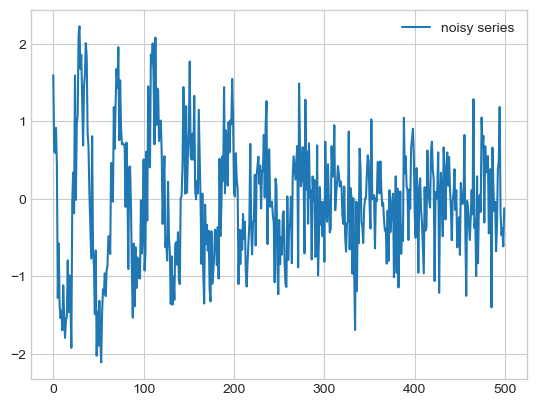

In [41]:
## пошумим и посмотрим на отделимость
np.random.seed(0)
ts_expcosine_noisy = ts_expcosine + np.random.normal(size = ts_expcosine.shape, scale = 0.5, )
plt.plot(ts_expcosine_noisy, label = 'noisy series')
plt.legend();

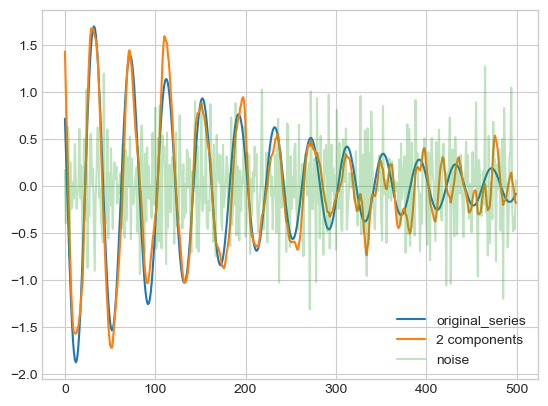

In [54]:
ts_ssa = SSA(l = 10).transform_to_series(ts_expcosine_noisy)
plt.plot(ts_expcosine, label = 'original_series')
plt.plot(ts_ssa[:2,:].sum(axis = 0), label = '2 components')
plt.plot(ts_ssa[2:, :].sum(axis = 0), label = 'noise', alpha = 0.3)
plt.legend();

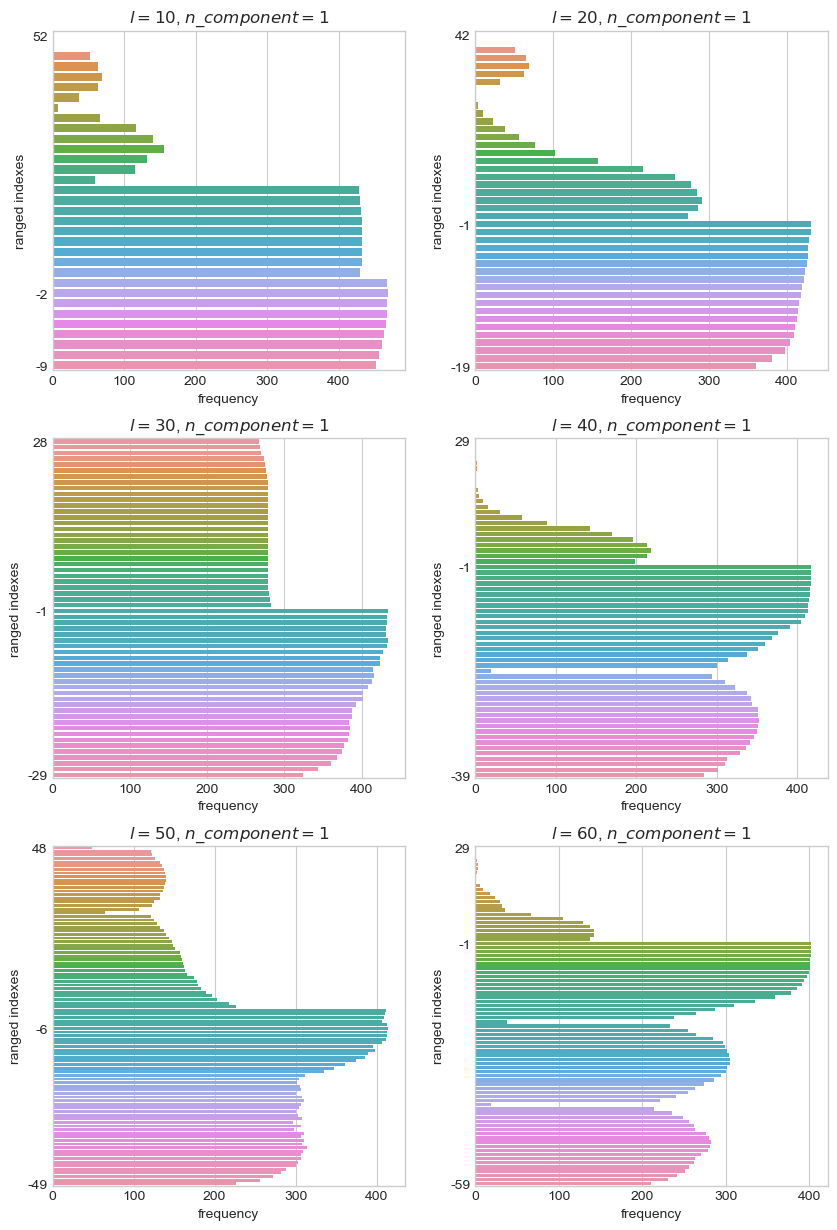

In [47]:
fig, ax = plt.subplots(3,2, figsize = (10,15))
n_component = 1
l_list = [10,20,30,40,50,60]
mean_len_list = []

for i, l in enumerate([10,20,30,40,50,60]):


    _, _, index_frequency, mean_len = analyse_component(ts_expcosine, l = l, n_component=n_component)
    mean_len_list.append(mean_len)
    plot_frequencies(index_frequency, l = l, n_component=n_component, ax = ax[i//2][i%2])

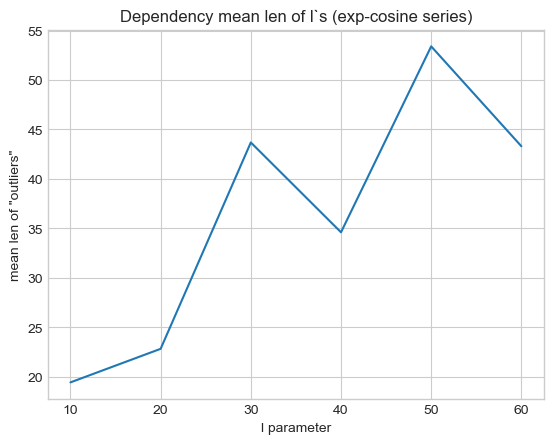

In [51]:
plt.plot(l_list, mean_len_list)
plt.xlabel('l parameter')
plt.ylabel('''mean len of "outliers"''')
plt.title('Dependency mean len of l`s (exp-cosine series)');
plt.savefig('Fig.5 Dependency mean len of l`s (exp-cosine series).png', dpi = 300)

In [22]:
def analyse_l(ts, n_components, l = 10):

    results = defaultdict(lambda: {})

    for threshold in range(l+20,ts.shape[0]):
      ts_1 = ts[:threshold]
      ts_2 = ts

      ssa = SSA(l = l)
      ssa_ts_1 = ssa.transform_to_series(ts_1)
      ssa_ts_2 = ssa.transform_to_series(ts_2)
      for n_component in n_components:
      
        ssa_ts_1_n = ssa_ts_1[n_component - 1, :]
        ssa_ts_2_n = ssa_ts_2[n_component - 1, :]
        results[n_component][f'vector_{threshold}'] = np.abs(ssa_ts_1_n - ssa_ts_2_n[:threshold])
        
    index_frequency = defaultdict(lambda:0)
    mean_lens = []
    for n_component in n_components:
      mean_len = 0
      for threshold in range(l+20,ts.shape[0]):
          indexes = get_index(results[n_component][f'vector_{threshold}'])
          for index in indexes:
              index_frequency[index] += 1
          mean_len += len(indexes) / (ts.shape[0] - l - 20)
      mean_lens.append(mean_len)


    return mean_lens

In [24]:
# полное исследование для пива
from tqdm import tqdm
l_list = np.arange(10,200,10)
n_components = np.arange(1,11)
mean_len_matrix = np.zeros((l_list.shape[0], n_components.shape[0]))

for i, l in enumerate(tqdm(l_list)):
        mean_lens = analyse_l(ts, l = l, n_components=n_components)
        mean_len_matrix[i, :] += mean_lens

np.save('beer_research', mean_len_matrix)

100%|███████████████████████████████████████████████████████████████████████████████| 19/19 [1:53:45<00:00, 359.25s/it]


In [ ]:
l_list = np.arange(10,200,10)
n_components = np.arange(1,11)
mean_len_matrix_exp = np.zeros((l_list.shape[0], n_components.shape[0]))

for i, l in enumerate(tqdm(l_list)):
        mean_lens = analyse_l(ts, l = l, n_components=n_components)
        mean_len_matrix_exp[i, :] += mean_lens

np.save('exp_cosine_research', mean_len_matrix_exp)

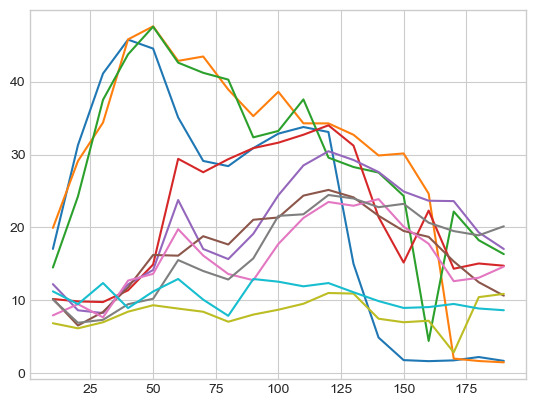

In [33]:
plt.plot(l_list, np.load('beer_research.npy'));

In [ ]:
for i in range(10):
  plt.plot(np.arange(10,200,10), mean_len_matrix[:,i], label = f'{i} component')

plt.legend();